# ARIMA model predicting future stock price

### 0. Load Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# from pandas.plotting import autocorrelation_plot
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose
# from pmdarima.arima.utils import nsdiffs
# from pmdarima.arima.utils import ndiffs
# import pmdarima as pm
# from scipy.signal import find_peaks

In [2]:
def plot_line(x, y, x_label = None, y_label = None, title = None):
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, ls = '-')
    plt.xlabel(x_label, fontsize = 13)
    plt.ylabel(y_label, fontsize = 13)
    plt.title(title, fontsize = 15)
#     plt.show()

In [3]:
def mrs(y, yhat):
    if len(y) != len(yhat):
        return 'error: length inconsistent'
    return sum(np.square(y - yhat))

In [4]:
def abs2(x):
    return x.real**2 + x.imag**2

### 1. Load SQLite database

In [5]:
#################################################
# 1. Database Setup
#################################################
engine = create_engine("sqlite:///../data/CompanyData.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save reference to the table
MasterData = Base.classes.MasterData
QuintileMonthlyData = Base.classes.QuintileMonthlyData
QuintileAvgData = Base.classes.QuintileAvgData

In [6]:
#################################################
# 2. Tables
#################################################
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
print("Table Names: ")
print(inspector.get_table_names())

Table Names: 
['FinData2', 'MasterData', 'PriceData2', 'QuintileAvgData', 'QuintileMonthlyData', 'findata', 'pricedata']


In [7]:
#################################################
# 3. Columns and DataType
#################################################
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('MasterData')
# Column names and DataType
df = pd.DataFrame({"name": [col['name'] for col in columns],
                  "type": [col['type'] for col in columns]})

In [8]:
df.head()

,name,type
0,monthend_date,DATE
1,ticker,VARCHAR(8)
2,price,FLOAT
3,wealth_index,FLOAT
4,end_wealth_index,FLOAT


### 2. Extract price from Individual STOCK

In [9]:
#################################################
# 1. choose stock & query
#################################################
ticker = 'MSFT'
session = Session(engine)
results = session.query(MasterData).filter(MasterData.ticker == ticker).all()

In [10]:
date = [res.monthend_date for res in results]
wealth_ind = [res.wealth_index for res in results]
end_wealth_ind = [res.end_wealth_index for res in results]
total_return = [res.total_return for res in results]

df = pd.DataFrame({'date': date, 
                   'wealth_ind': wealth_ind, 
                   'mon_ahead_wealth_ind': end_wealth_ind,
                   'total_return': total_return
                  })
df.head()

,date,wealth_ind,mon_ahead_wealth_ind,total_return
0,2014-11-30,43.0679,41.8428,-2.844578
1,2014-12-31,41.8428,36.3929,-13.024702
2,2015-01-31,36.3929,39.7818,9.311981
3,2015-02-28,39.7818,36.8877,-7.274935
4,2015-03-31,36.8877,44.1274,19.626325


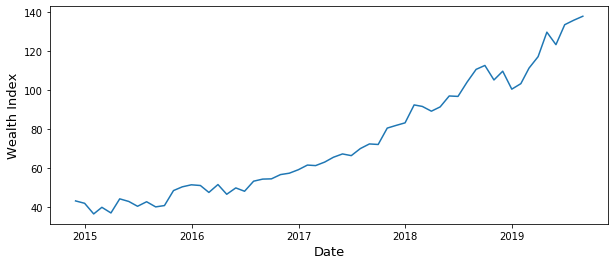

In [11]:
#################################################
# 2. plot raw data
#################################################

plot_line(df.date, df.wealth_ind, 'Date','Wealth Index', None)

## 3. LSTM

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [13]:
msft = pd.read_csv('MSFT.csv')
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-10-23,44.619999,45.450001,44.529999,45.020000,40.300430,45451900
1,2014-10-24,46.830002,46.900002,45.180000,46.130001,41.294075,61076700
2,2014-10-27,45.709999,46.099998,45.709999,45.910000,41.097130,30371300
3,2014-10-28,45.860001,46.500000,45.770000,46.490002,41.616329,29049800
4,2014-10-29,46.439999,46.700001,46.340000,46.619999,41.732697,30276100


In [14]:
#################################################
# 1. data cleaning and preparation
#################################################
## copy col, Min Max rescale to (0,1)
cols = ['Date', 'Open']
data = msft[cols].copy()

scaler = MinMaxScaler(feature_range = (0, 1))

data['Open'] = scaler.fit_transform(data[['Open']])
train = data[0:-200]
test = data[-200::]
data.head()

,Date,Open
0,2014-10-23,0.042309
1,2014-10-24,0.064156
2,2014-10-27,0.053084
3,2014-10-28,0.054567
4,2014-10-29,0.060301


In [15]:
n = 10    # feature length for each label (how many past data is used in each label)
feature = [] # contains historic price T-n: T 
label = []   # contain price at time T

for i in range(n,len(train)):
    feature.append(list(train['Open'][i - n: i]))
    label.append(data['Open'][i])
 
label = np.array(label).reshape(-1, 1) # cast to np.array for training
feature  = np.array(feature)
feature = np.reshape(feature, (feature.shape[0], n, 1)) # shape(m, n, 1) 
                                                        # ==> m: # sample; n: feature length; d = feature dim (1)

print("feature shape:", feature.shape)
print("label shape  :", label.shape)

feature shape: (1049, 10, 1)
label shape  : (1049, 1)


In [16]:
#################################################
# 2. prepare test feature
#################################################
label_test = np.array(test['Open']).reshape(-1, 1)

feature_test = [] # contains historic price T-n: T 

for i in range(len(test)):
    ind = i - len(test)
    feature_test.append(list(data['Open'][ind - n: ind]))

label_test = np.array(label_test).reshape(-1, 1) # cast to np.array for training
feature_test  = np.array(feature_test)
feature_test = np.reshape(feature_test, (feature_test.shape[0], n, 1))

In [17]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp

def data(batch_size, time_steps):
    """
    function that returns data to be fed into objective function and model is trained on it subsequently.
    """
    global mat

    BATCH_SIZE = batch_size
    TIME_STEPS = time_steps
    x_train, x_test = train_test_split(mat, train_size=0.8, test_size=0.2, shuffle=False)
    # scale the train and test dataset
    min_max_scaler = MinMaxScaler()
    x_train = min_max_scaler.fit_transform(x_train)
    x_test = min_max_scaler.transform(x_test)

    x_train_ts, y_train_ts = build_timeseries(x_train, 3, TIME_STEPS)
    x_test_ts, y_test_ts = build_timeseries(x_test, 3, TIME_STEPS)
    x_train_ts = trim_dataset(x_train_ts, BATCH_SIZE)
    y_train_ts = trim_dataset(y_train_ts, BATCH_SIZE)
    x_test_ts = trim_dataset(x_test_ts, BATCH_SIZE)
    y_test_ts = trim_dataset(y_test_ts, BATCH_SIZE)
    return x_train_ts, y_train_ts, x_test_ts, y_test_ts

search_space = {
    'batch_size': hp.choice('bs', [30,40,50,60,70]),
    'time_steps': hp.choice('ts', [30,50,60,80,90]),
    'lstm1_nodes': hp.choice('units_lsmt1', [70,80,100,130]),
    'lstm1_dropouts': hp.uniform('dos_lstm1',0,1),
    'lstm_layers': hp.choice('num_layers_lstm',[
        {
            'layers':'one', 
        },
        {
            'layers':'two',
            'lstm2_nodes': hp.choice('units_lstm2', [20,30,40,50]),
            'lstm2_dropouts': hp.uniform('dos_lstm2',0,1)  
        }
        ]),
    'dense_layers': hp.choice('num_layers_dense',[
        {
            'layers':'one'
        },
        {
            'layers':'two',
            'dense2_nodes': hp.choice('units_dense', [10,20,30,40])
        }
        ]),
    "lr": hp.uniform('lr',0,1),
    "epochs": hp.choice('epochs', [30, 40, 50, 60, 70]),
    "optimizer": hp.choice('optmz',["sgd", "rms"])
}

def create_model_hypopt(params):
    """
    This method is called for each combination of parameter set to train the model and validate it against validation data
    to see all the results, from which best can be selected.
    """
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    # For most cases preparation of data can be done once and used 'n' number of times in this method to train the model
    # but in this case we want to find optimal value for batch_size and time_steps too. So our data preparation has to be done
    # based on that. Hence calling it from here.
    x_train_ts, y_train_ts, x_test_ts, y_test_ts = data(batch_size, time_steps)
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(params["lstm1_nodes"], batch_input_shape=(batch_size, time_steps, x_train_ts.shape[2]), dropout=params["lstm1_dropouts"],
                        recurrent_dropout=params["lstm1_dropouts"], stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))  
    if params["lstm_layers"]["layers"] == "two":
        lstm_model.add(LSTM(params["lstm_layers"]["lstm2_nodes"], dropout=params["lstm_layers"]["lstm2_dropouts"]))
    else:
        lstm_model.add(Flatten())

    if params["dense_layers"]["layers"] == 'two':
        lstm_model.add(Dense(params["dense_layers"]["dense2_nodes"], activation='relu'))
    
    lstm_model.add(Dense(1, activation='sigmoid'))

    lr = params["lr"]
    epochs = params["epochs"]
    if params["optimizer"] == 'rms':
        optimizer = optimizers.RMSprop(lr=lr)
    else:
        optimizer = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)  # binary_crossentropy
    history = lstm_model.fit(x_train_ts, y_train_ts, epochs=epochs, verbose=2, batch_size=batch_size,
                             validation_data=[x_test_ts, y_test_ts],
                             callbacks=[your_csv_logger])
    val_error = np.amin(history.history['val_loss']) 
    print('Best validation error of epoch:', val_error)
    return {'loss': val_error, 'status': STATUS_OK, 'model': lstm_model} # if accuracy use '-' sign
    # return history, lstm_model

In [18]:
# Trails object let's you return and store extra information from objective function, which
# can be analysed later. Check "trails.trails" which returns all the list of dictionaries 
trials = Trials()


In [19]:
best_run, best_model = optim.minimize(model=create_model,
                                      data=data_dummy,
                                      algo=tpe.suggest,
                                      max_evals=2000,
                                      trials=Trials())

NameError: name 'optim' is not defined

In [89]:
#################################################
# 3. train LSTM
#################################################
# parameters to tune
unit_n = 50
dropout = 0.2
lr = 0.01

def create_model(batch_size):
    # MODEL
    # 1. input layer
    model = Sequential()
    model.add(LSTM(units=unit_n, return_sequences=True, input_shape=(feature.shape[1], 1)))
    model.add(Dropout(dropout))
    # 2. LSTM training layers
    model.add(LSTM(units=unit_n, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=unit_n))
    model.add(Dropout(dropout))
    # 3. Dense layer, preparing for outpu
    model.add(Dense(20,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # model fitting
    optimizer = optimizers.RMSprop(lr=lr)
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['accuracy'])
    model.fit(feature, label, epochs = 10, batch_size = batch_size)#, verbose=0)
    return model

In [90]:
mrs_min = np.Infinity
winner = 0
for i in range(1,2):
    model = create_model(i)
    predictions = model.predict(feature_test)
    
    currentmrs = mrs(label_test, predictions)
    print(i, currentmrs)
    if  currentmrs < mrs_min:
        winner = i
        mrs_min = currentmrs
print(winner, mrs_min)

Epoch 1/10
1049/1049 [==============================] - 9s 8ms/step - loss: 0.0167 - accuracy: 9.5329e-04
Epoch 2/10
1049/1049 [==============================] - 8s 8ms/step - loss: 0.0043 - accuracy: 9.5329e-04
Epoch 3/10
1049/1049 [==============================] - 8s 8ms/step - loss: 0.0034 - accuracy: 9.5329e-04
Epoch 4/10
1049/1049 [==============================] - 8s 7ms/step - loss: 0.0029 - accuracy: 9.5329e-04
Epoch 5/10
1049/1049 [==============================] - 8s 7ms/step - loss: 0.0025 - accuracy: 9.5329e-04
Epoch 6/10
1049/1049 [==============================] - 8s 7ms/step - loss: 0.0024 - accuracy: 9.5329e-04
Epoch 7/10
1049/1049 [==============================] - 8s 7ms/step - loss: 0.0019 - accuracy: 9.5329e-04
Epoch 8/10
1049/1049 [==============================] - 8s 8ms/step - loss: 0.0019 - accuracy: 9.5329e-04
Epoch 9/10
1049/1049 [==============================] - 8s 8ms/step - loss: 0.0018 - accuracy: 9.5329e-04
Epoch 10/10
1049/1049 [=======================

In [91]:
#################################################
# 4. prediction
#################################################
predictions = model.predict(feature_test)
predictions = scaler.inverse_transform(predictions)

predict_train = model.predict(feature)
predict_train = scaler.inverse_transform(predict_train)

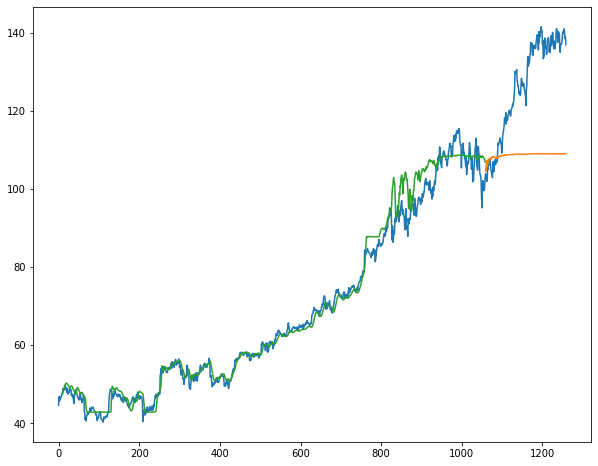

In [92]:
plt.figure(figsize = (10,8))
plt.plot(msft['Open'][::])
plt.plot(test.index, predictions)
plt.plot(train.index[n::], predict_train)